This is Kelly Wiseman's Ipython notebook from the completed CriteoLabs Kaggle competition. Check out Kaggle's website for more competition details and data files.

# CriteoLabs Display Advertising Challenge
Display advertising is a billion dollar effort and one of the central uses of machine learning on the Internet. However, its data and methods are usually kept under lock and key. In this research competition, CriteoLabs is sharing a week’s worth of data for you to develop models predicting ad click-through rate (CTR). Given a user and the page he is visiting, what is the probability that he will click on a given ad?

## Goal: Predict Click-through Rate
Kaggle provided seven days of Criteo ad data for training and one day of test data.  For the competition, we were to submit the predicted probability of click for each ad in the test set.  Kaggle scores a portion of the test set publicly during the competition period, and reserves a portion for private scoring at the end of the competition. Submissions are evaluated using the logarithmic loss error metric, which provides extreme punishments for being both confident and wrong.

## Data
train.csv - The training set consists of a portion of Criteo's traffic over a period of seven days. Each row corresponds to a display ad served by Criteo. Positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates in order to reduce the dataset size. The examples are chronologically ordered. 
* Label -  Target variable that indicates if an ad was clicked (1) or not (0)
* I1-I13 - A total of 13 columns of integer features (mostly count features).
* C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.

test.csv - The test set is computed in the same way as the training set but for events on the day following the training period.

random_submission.csv - A sample submission file in the correct format.

## My Approach
Since the training data was so large, I decided to separately model each day of the training set (seven days total), and then average the daily predictions. In my final model, I include all of the integer features (I1-I13), and the categorical features with less than 10,000 distinct text values (16 of the categorical features). After combining the integer and encoded categorical features, there were about 18,300 features for each day of training data.

## Results
My models trained with the last day of ad data (closest in time to the test data) performed best during the public and private scoring period. I had guessed that my averaged models, that fitted the entire training set, would perform better on the complete test set. I therefore submitted them for the final competition score, and the weighted average model scored higher at 0.49629 and ranked 443/718. The top ranked team in the competition scored 0.44464.  I believe that I performed poorly in this competition because my models were too simple, and not extensively cross-validated.  My limited computing power prevented me from running more complex models, such as decision trees or ensemble classification methods. In addition, I did not perform a grid search, with cross-validation, on the SGD model parameters. I manually fine tuned the parameters and checked their public Kaggle score, submitting a total of 32 entries in the competition.

# Data Analysis

In [7]:
# import necessary python packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
# Set up some better defaults for matplotlib
from matplotlib import rcParams
import brewer2mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

## Use both Integer and Categorical data

I ran the following code for each day of training data (1.66 GB).  The last day of the training data is shown below.

In [122]:
# Features to use
integer_features = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']
categorical_features = ['C1','C2','C5','C6','C8','C9','C11','C13','C14','C17','C18','C19','C20','C22','C23','C25']

# Read data files into Pandas dataframe format
train_int_df = pd.read_csv('data/criteo/train_day7.csv', header=0)[integer_features]
print 'done loading train_int'
train_cat_df = pd.read_csv('data/criteo/train_day7.csv', header=0)[categorical_features]
print 'done loading train_cat'
test_int_df = pd.read_csv('data/criteo/test.csv', header=0)[integer_features]
print 'done loading test_int'
test_cat_df = pd.read_csv('data/criteo/test.csv', header=0)[categorical_features]
print 'done loading test_cat'
outcomes_df = pd.read_csv('data/criteo/train_day7.csv', header=0)['Label']
print 'done loading outcomes'

# Read submission file into Pandas dataframe format
random_submission = pd.read_csv('data/criteo/random_submission.csv', header=0)

# Convert data to Numpy NDFrame
train_int = train_int_df.values
train_cat = train_cat_df.values
test_int = test_int_df.values
test_cat = test_cat_df.values
outcomes = outcomes_df.values

# Check that data was read in correctly
print np.shape(train_int), np.shape(train_cat), np.shape(test_int), np.shape(test_cat), np.shape(outcomes)

## Preprocess the data ##
from sklearn import preprocessing

# Training data #
# Fill in the missing integers with average feature values
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
train_int_imputed = imp.fit_transform(train_int)

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(train_int_imputed)
train_int_scaled = scaler.transform(train_int_imputed)

# Test data #
# Fill in the missing integers with average feature values
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
test_int_imputed = imp.fit_transform(test_int)

# Standardize features by removing the mean and scaling to unit variance
# Uses the same scaling as the training data
test_int_scaled = scaler.transform(test_int_imputed)

# Give numerical labels to the categorical data
from sklearn.preprocessing import LabelEncoder
for n in range(0,len(categorical_features)):
    le = LabelEncoder()
    le.fit(np.concatenate((train_cat[:,n],test_cat[:,n]),axis=0))
    train_cat[:,n] = le.transform(train_cat[:,n])
    test_cat[:,n] = le.transform(test_cat[:,n])
print np.shape(train_cat), np.shape(test_cat)

# Encode the numerical labels 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(train_cat)
train_enc = enc.transform(train_cat)
test_enc = enc.transform(test_cat)

# Concatenate the preprocessed integer and categorical features
from scipy.sparse import hstack
Xtrain_enc = hstack((train_int_scaled, train_enc))
Xtest_enc = hstack((test_int_scaled, test_enc))
print np.shape(Xtrain_enc), np.shape(Xtest_enc)

done loading train_int
done loading train_cat
done loading test_int
done loading test_cat
done loading outcomes
(6548658, 13) (6548658, 16) (6042135, 13) (6042135, 16) (6548658,)
(6548658, 16) (6042135, 16)
(6548658, 18323) (6042135, 18323)


## Machine Learning Models

### Stochastic Gradient Descent Classifier

This estimator implements regularized linear models (logistic regression in this case) with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated one sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 (used in my models) or the absolute norm L1 or a combination of both (Elastic Net). There are two parameters to tune: the number of iterations and the regularization parameter alpha. 

SGD is very efficient and is good for large-scale and sparse machine learning problems, such as text classification. For this competition, SGD performs slightly worse (less than 1% difference) than similarly regularized logistic regression models, but is much faster. For example, running a SGD model on one day's training data takes 105 minutes on my machine, but over two days using a standard logistic regression model.

I manually tuned the alpha regularization parameter and the number of iterations.  The training loss generally improves quickly within the first ten iterations, and continues to slowly decay with more iterations.  For the final models, I used the parameter values of alpha = 1e-5 and number of interations = 300,  which provide a good balance of model speed and loss score.  The public and private Kaggle scores to the daily models were very similar, with the private scores being about 0.1% better. The worst performing model was based on the day 1 training data, and had a private Kaggle score of  0.49884.  The day 7 model had a score of 0.49615.  The averaged model, with equal weights for all the days, scored 0.49662.  The averaged model, with linearly increasing weights, scored 0.49629.  The day 7 model actually out-performed both averaged models.


In [123]:
## Make prediction with SGD Classifier ##
# Run model on each day of the training data

from sklearn import linear_model

# Incrementally trains logistic regression with loss=log
clf = linear_model.SGDClassifier(loss='log', penalty='l2', n_iter=300, shuffle=True, verbose=1,
                                 alpha = 1e-5)
clf.fit(Xtrain_enc, outcomes)
print 'done fitting'

# Make preditions and write to file
preds_x = clf.predict_proba(Xtest_enc)[:,1]
random_submission['Predicted'] = preds_x
random_submission.to_csv('data/criteo/SGD1a5_l2_i300_day7_10000.csv', index = False)

-- Epoch 1
Norm: 22.11, NNZs: 18323, Bias: -1.065992, T: 6548658, Avg. loss: 0.835641
Total training time: 22.57 seconds.
-- Epoch 2
Norm: 21.43, NNZs: 18323, Bias: -1.070248, T: 13097316, Avg. loss: 0.670999
Total training time: 44.41 seconds.
-- Epoch 3
Norm: 21.24, NNZs: 18323, Bias: -1.073803, T: 19645974, Avg. loss: 0.613892
Total training time: 80.44 seconds.
-- Epoch 4
Norm: 21.12, NNZs: 18323, Bias: -1.074698, T: 26194632, Avg. loss: 0.584690
Total training time: 96.75 seconds.
-- Epoch 5
Norm: 21.06, NNZs: 18323, Bias: -1.076457, T: 32743290, Avg. loss: 0.566897
Total training time: 106.43 seconds.
-- Epoch 6
Norm: 21.07, NNZs: 18323, Bias: -1.077424, T: 39291948, Avg. loss: 0.554904
Total training time: 131.14 seconds.
-- Epoch 7
Norm: 21.01, NNZs: 18323, Bias: -1.078400, T: 45840606, Avg. loss: 0.546238
Total training time: 141.96 seconds.
-- Epoch 8
Norm: 21.00, NNZs: 18323, Bias: -1.079216, T: 52389264, Avg. loss: 0.539694
Total training time: 151.32 seconds.
-- Epoch 9
No

Norm: 20.91, NNZs: 18323, Bias: -1.092153, T: 432211428, Avg. loss: 0.497725
Total training time: 987.64 seconds.
-- Epoch 67
Norm: 20.91, NNZs: 18323, Bias: -1.092182, T: 438760086, Avg. loss: 0.497632
Total training time: 1000.70 seconds.
-- Epoch 68
Norm: 20.91, NNZs: 18323, Bias: -1.092233, T: 445308744, Avg. loss: 0.497542
Total training time: 1018.46 seconds.
-- Epoch 69
Norm: 20.91, NNZs: 18323, Bias: -1.092321, T: 451857402, Avg. loss: 0.497455
Total training time: 1028.41 seconds.
-- Epoch 70
Norm: 20.91, NNZs: 18323, Bias: -1.092530, T: 458406060, Avg. loss: 0.497370
Total training time: 1037.04 seconds.
-- Epoch 71
Norm: 20.91, NNZs: 18323, Bias: -1.092674, T: 464954718, Avg. loss: 0.497287
Total training time: 1045.50 seconds.
-- Epoch 72
Norm: 20.91, NNZs: 18323, Bias: -1.092665, T: 471503376, Avg. loss: 0.497207
Total training time: 1054.73 seconds.
-- Epoch 73
Norm: 20.91, NNZs: 18323, Bias: -1.092875, T: 478052034, Avg. loss: 0.497128
Total training time: 1063.73 second

Norm: 20.91, NNZs: 18323, Bias: -1.096127, T: 851325540, Avg. loss: 0.494626
Total training time: 1683.93 seconds.
-- Epoch 131
Norm: 20.91, NNZs: 18323, Bias: -1.096279, T: 857874198, Avg. loss: 0.494601
Total training time: 1691.02 seconds.
-- Epoch 132
Norm: 20.91, NNZs: 18323, Bias: -1.096348, T: 864422856, Avg. loss: 0.494577
Total training time: 1697.89 seconds.
-- Epoch 133
Norm: 20.91, NNZs: 18323, Bias: -1.096319, T: 870971514, Avg. loss: 0.494553
Total training time: 1707.18 seconds.
-- Epoch 134
Norm: 20.91, NNZs: 18323, Bias: -1.096445, T: 877520172, Avg. loss: 0.494529
Total training time: 1714.00 seconds.
-- Epoch 135
Norm: 20.91, NNZs: 18323, Bias: -1.096415, T: 884068830, Avg. loss: 0.494506
Total training time: 1721.14 seconds.
-- Epoch 136
Norm: 20.91, NNZs: 18323, Bias: -1.096469, T: 890617488, Avg. loss: 0.494483
Total training time: 1727.53 seconds.
-- Epoch 137
Norm: 20.91, NNZs: 18323, Bias: -1.096621, T: 897166146, Avg. loss: 0.494460
Total training time: 1734.9

Norm: 20.91, NNZs: 18323, Bias: -1.098573, T: 1270439652, Avg. loss: 0.493544
Total training time: 3699.66 seconds.
-- Epoch 195
Norm: 20.91, NNZs: 18323, Bias: -1.098656, T: 1276988310, Avg. loss: 0.493533
Total training time: 3747.06 seconds.
-- Epoch 196
Norm: 20.91, NNZs: 18323, Bias: -1.098625, T: 1283536968, Avg. loss: 0.493522
Total training time: 3796.21 seconds.
-- Epoch 197
Norm: 20.91, NNZs: 18323, Bias: -1.098692, T: 1290085626, Avg. loss: 0.493510
Total training time: 3897.74 seconds.
-- Epoch 198
Norm: 20.90, NNZs: 18323, Bias: -1.098701, T: 1296634284, Avg. loss: 0.493499
Total training time: 3915.38 seconds.
-- Epoch 199
Norm: 20.91, NNZs: 18323, Bias: -1.098727, T: 1303182942, Avg. loss: 0.493488
Total training time: 3961.61 seconds.
-- Epoch 200
Norm: 20.90, NNZs: 18323, Bias: -1.098775, T: 1309731600, Avg. loss: 0.493478
Total training time: 4011.89 seconds.
-- Epoch 201
Norm: 20.90, NNZs: 18323, Bias: -1.098828, T: 1316280258, Avg. loss: 0.493467
Total training time

Norm: 20.90, NNZs: 18323, Bias: -1.100333, T: 1683005106, Avg. loss: 0.492997
Total training time: 5697.18 seconds.
-- Epoch 258
Norm: 20.90, NNZs: 18323, Bias: -1.100328, T: 1689553764, Avg. loss: 0.492990
Total training time: 5710.15 seconds.
-- Epoch 259
Norm: 20.90, NNZs: 18323, Bias: -1.100314, T: 1696102422, Avg. loss: 0.492984
Total training time: 5745.60 seconds.
-- Epoch 260
Norm: 20.90, NNZs: 18323, Bias: -1.100350, T: 1702651080, Avg. loss: 0.492977
Total training time: 5761.40 seconds.
-- Epoch 261
Norm: 20.90, NNZs: 18323, Bias: -1.100402, T: 1709199738, Avg. loss: 0.492971
Total training time: 5782.43 seconds.
-- Epoch 262
Norm: 20.90, NNZs: 18323, Bias: -1.100438, T: 1715748396, Avg. loss: 0.492964
Total training time: 5869.55 seconds.
-- Epoch 263
Norm: 20.90, NNZs: 18323, Bias: -1.100465, T: 1722297054, Avg. loss: 0.492958
Total training time: 5885.70 seconds.
-- Epoch 264
Norm: 20.90, NNZs: 18323, Bias: -1.100388, T: 1728845712, Avg. loss: 0.492952
Total training time

## Average the models

In [16]:
# Read submission files into Pandas dataframe format
day1_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day1_10000.csv', header=0)['Predicted']
day2_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day2_10000.csv', header=0)['Predicted']
day3_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day3_10000.csv', header=0)['Predicted']
day4_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day4_10000.csv', header=0)['Predicted']
day5_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day5_10000.csv', header=0)['Predicted']
day6_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day6_10000.csv', header=0)['Predicted']
day7_df = pd.read_csv('data/criteo/SGD1a5_l2_i300_day7_10000.csv', header=0)['Predicted']

# Merge the predictions from days 1 through 7
day_merge = pd.concat((day1_df,day2_df,day3_df,day4_df,day5_df,day6_df,day7_df), axis=1)
day_merge.columns=['Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Day_7']
print day_merge.head()

# Create prediction by averaging the individual results from days 1 through 7
day_avg = np.mean(day_merge, axis=1)
random_submission['Predicted'] = day_avg
random_submission.to_csv('data/criteo/SGD1a5_l2_i300_avg_10000.csv', index = False)

# Create prediction by averaging the individual results from days 1 through 7 with weights
# the days are weighted by proximity in time to the test data, i.e. Day 1 is weighted the weakest and Day 7 the strongest
weights = [1,2,3,4,5,6,7]
day_Wavg = np.average(day_merge, axis=1, weights=weights)
random_submission['Predicted'] = day_Wavg
random_submission.to_csv('data/criteo/SGD1a5_l2_i300_Wavg_10000.csv', index = False)


Day_1     Day_2     Day_3     Day_4     Day_5     Day_6     Day_7
0  0.143274  0.131825  0.143951  0.127745  0.132533  0.142817  0.143085
1  0.117254  0.109735  0.108426  0.098443  0.125410  0.132112  0.142853
2  0.229700  0.255311  0.253135  0.201746  0.217242  0.203316  0.214502
3  0.488708  0.496523  0.470901  0.484663  0.490130  0.547576  0.553420
4  0.209705  0.197398  0.189035  0.198159  0.184803  0.198819  0.203943

## Compare the daily predictions

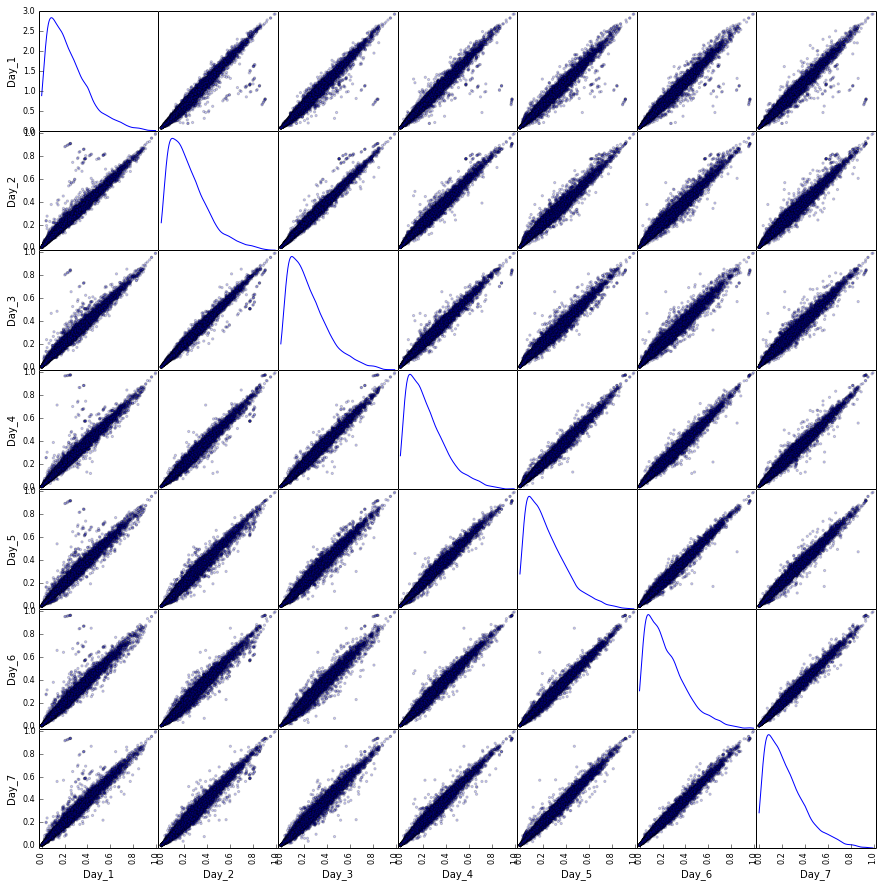

In [17]:
_ = pd.scatter_matrix(day_merge.loc[:10000,'Day_1':'Day_7'], figsize=(15,15), diagonal='kde', alpha=0.2)

In [20]:
# Daily model correlation rates #
day_merge.corr()

Day_1     Day_2     Day_3     Day_4     Day_5     Day_6     Day_7
Day_1  1.000000  0.985907  0.984852  0.984689  0.981264  0.981899  0.981600
Day_2  0.985907  1.000000  0.990402  0.986448  0.980870  0.981273  0.980542
Day_3  0.984852  0.990402  1.000000  0.987984  0.982824  0.980669  0.979489
Day_4  0.984689  0.986448  0.987984  1.000000  0.989562  0.985870  0.984129
Day_5  0.981264  0.980870  0.982824  0.989562  1.000000  0.986764  0.984942
Day_6  0.981899  0.981273  0.980669  0.985870  0.986764  1.000000  0.990951
Day_7  0.981600  0.980542  0.979489  0.984129  0.984942  0.990951  1.000000

## Further exploration with only integer features

I used the competition as an excuse to test out several feature selection and model evaluation methods in the Sklearn Python package. For this additional exploration, I only used the integer features from the last tenth of the training data.

In [124]:
# Features to use
integer_features = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']

# Read data files into Pandas dataframe format
train_int_df = pd.read_csv('data/criteo/train_10.csv', header=0)[integer_features]
print 'done loading train_int'
test_int_df = pd.read_csv('data/criteo/test.csv', header=0)[integer_features]
print 'done loading test_int'
outcomes_df = pd.read_csv('data/criteo/train_10.csv', header=0)['Label']
print 'done loading outcomes'

# Read submission file into Pandas dataframe format
random_submission = pd.read_csv('data/criteo/random_submission.csv', header=0)

# Convert data to Numpy NDFrame
train_int = train_int_df.values
test_int = test_int_df.values
outcomes = outcomes_df.values

# Check that data was read in correctly
print np.shape(train_int), np.shape(test_int), np.shape(outcomes)

## Preprocess the data ##
from sklearn import preprocessing

# Training data #
# Fill in the missing integers with average feature values
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
train_int_imputed = imp.fit_transform(train_int)

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(train_int_imputed)
train_int_scaled = scaler.transform(train_int_imputed)

# Test data #
# Fill in the missing integers with average feature values
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
test_int_imputed = imp.fit_transform(test_int)

# Standardize features by removing the mean and scaling to unit variance
# Uses the same scaling as the training data
test_int_scaled = scaler.transform(test_int_imputed)

done loading train_int
done loading test_int
done loading outcomes
(4583988, 13) (6042135, 13) (4583988,)


## Feature ranking/selection

### Univariate feature selection

In [4]:
""" Where a statistical test is applied to each feature individually. 
You retain only the best features according to the test outcome scores."""

# These feature selection objects take as input a scoring function that returns univariate p-values
# for regression: f_regression
# for classification: chi2 or f_classif (Anova F-value)

# Feature selection using the Kbest
# It removes all but the k-highest scoring features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

kbest = SelectKBest(f_classif, k=5)
kbest.fit(train_int_scaled, outcomes)
print 'kbest scores', kbest.scores_
print 'kbest p-values', kbest.pvalues_

# Feature selection using the False Positive Rate test
# It controls the total amount of false detections.
from sklearn.feature_selection import SelectFpr

fpr = SelectFpr(f_classif, alpha=0.05)
fpr.fit(train_int_scaled, outcomes)
print 'fpr scores', fpr.scores_
print 'fpr p-values', fpr.pvalues_

# Feature selection using the False Discovery Rate test
# This uses the Benjamini-Hochberg procedure. alpha is the target false discovery rate.
from sklearn.feature_selection import SelectFdr

fdr = SelectFdr(f_classif, alpha=0.05)
fdr.fit(train_int_scaled, outcomes)
print 'fdr scores', fdr.scores_
print 'fdr p-values', fdr.pvalues_

# Feature selection using the Family-wise error rate test
from sklearn.feature_selection import SelectFwe

fwe = SelectFwe(f_classif, alpha=0.05)
fwe.fit(train_int_scaled, outcomes)
print 'fwe scores', fwe.scores_
print 'fwe p-values', fwe.pvalues_

//anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:134: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:134: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


kbest scores [  25168.009241      9102.31728299    1674.16080592    8919.755839
   29330.7138947    18527.99727579   30881.56346532    1797.08232759
    1945.44574831   89147.18177004  106089.63591839   11924.7281805
   19809.22059082]
kbest p-values [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
fpr scores

//anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:303: UserWarning: Duplicate p-values. Result may depend on feature ordering.There are probably duplicate features, or you used a classification score for a regression task.
  warn("Duplicate p-values. Result may depend on feature ordering."
//anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:134: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


 [  25168.009241      9102.31728299    1674.16080592    8919.755839
   29330.7138947    18527.99727579   30881.56346532    1797.08232759
    1945.44574831   89147.18177004  106089.63591839   11924.7281805
   19809.22059082]
fpr p-values [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
fdr scores [  25168.009241      9102.31728299    1674.16080592    8919.755839
   29330.7138947    18527.99727579   30881.56346532    1797.08232759
    1945.44574831   89147.18177004  106089.63591839   11924.7281805
   19809.22059082]
fdr p-values [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
fwe scores [  25168.009241      9102.31728299    1674.16080592    8919.755839
   29330.7138947    18527.99727579   30881.56346532    1797.08232759
    1945.44574831   89147.18177004  106089.63591839   11924.7281805
   19809.22059082]
fwe p-values [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


//anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:134: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


### Feature selection with Randomized Logistic Regression

In [6]:
## Feature selection with Randomized Logistic Regression ##
from sklearn import linear_model

rlr = linear_model.RandomizedLogisticRegression(C=1.0, scaling=0.5, sample_fraction = 0.75, 
                                                selection_threshold=0.25, n_resampling=40,
                                                verbose=1, tol=0.0001)
rlr.fit(train_int_scaled, outcomes)

# feature scores are between 0 and 1, higher values being more favorable
print rlr.scores_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 69.5min finished


[ 1.   1.   1.   1.   1.   1.   1.   1.   0.8  1.   1.   1.   1. ]


### Recursive feature elimination with cross-validation

I used recursive feature elimination with 3-fold cross-validation to rank the integer features.  I used logistic regression with the regularization parameter C = 0.001 as the estimator and varied the scoring function. The logistic loss scoring function (used to score the competition), ranks all of the integers 1 - meaning they should all be included in the model. The log-loss peaks at -0.542 (0 is best possible score), but there is not much improvement after 5 of the 13 integer features are included. The model accuracy peaks at 0.744 (1 is best possible score) and all of the features are ranked 1 except for I9. The model recall is horrible, peaking at 0.06 (1 is best score) with all 13 features. The model precision peaks at 0.56 (1 is best possible score), and all of the features are ranked 1 except for I9.
 
The areas under the ROC curve and precision-recall curve (average precision) provide the most differentiation among the integer features.  They both rank I9 worst, and the top performing features are I6, I5, I11, and I13.

#### Using log-loss as metric

ranking [1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 13


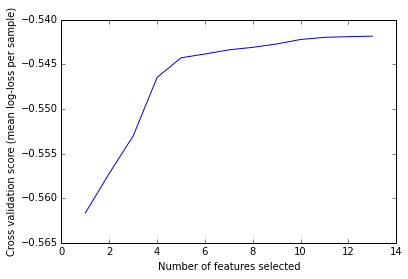

In [37]:
""" This is the loss function used in logistic regression and extensions of it such as neural networks,
defined as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions. 

For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, 
the log loss is:

-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))"""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=3, scoring='log_loss')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean log-loss)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using ROC AUC as metric

ranking [ 9  7  8  6  1  1  3  5 10  2  1  4  1]
Optimal number of features : 4


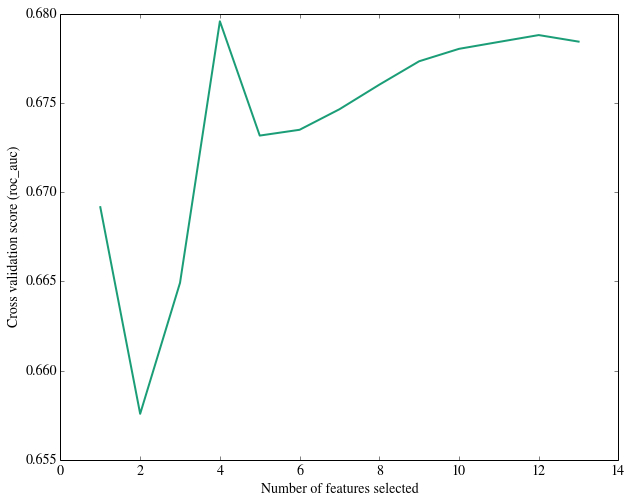

In [125]:
"""ROC curves compare true positive rate on the Y axis, and false positive rate on the X axis.
This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero,
and a true positive rate of one. This is not very realistic, but it does mean that a larger area
under the curve (AUC) is usually better. Random guesses equate to AUC of 0.5

AUC score evaluation:
0.90-1.0 = excellent
0.80-0.90 = good
0.70-0.80 = fair
0.60-0.70 = poor
0.50-0.60 = fail
 """

from sklearn import linear_model
from sklearn.feature_selection import RFECV
 
estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='roc_auc')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc_auc)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using accuracy as metric

ranking [1 1 1 1 1 1 1 1 2 1 1 1 1]
Optimal number of features : 12


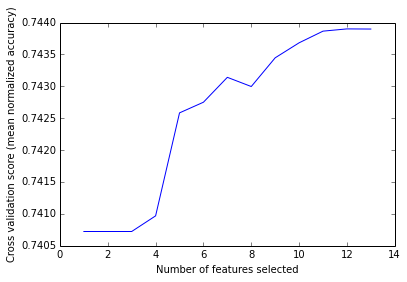

In [34]:
"""The accuracy is the ratio of (TP + TN) / number of samples.
It is a good metric if the classes are balanced.

The best value is 1 and the worst value is 0."""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='accuracy')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean normalized accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using recall as metric

ranking [1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 13


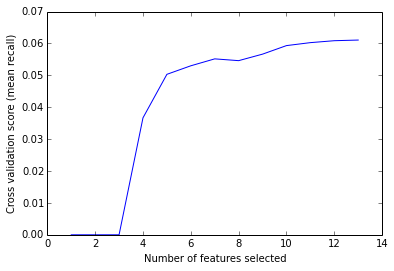

In [38]:
"""The recall is the ratio of TP / (TP + FN).
The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0."""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='recall')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean recall)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using precision as metric

ranking [1 1 1 1 1 1 1 1 2 1 1 1 1]
Optimal number of features : 12


//anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1734: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [1]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [1]. 
  average=average)


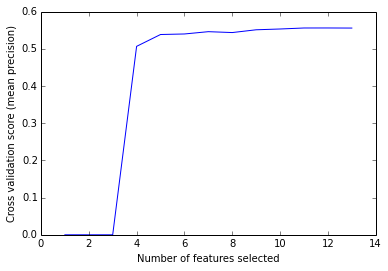

In [39]:
""" The precision is the ratio of TP / (TP + FP). 
The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0."""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='precision')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean precision)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using F1 score as metric

ranking [1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 13


//anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1249: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [1]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [1]. 
  average=average)


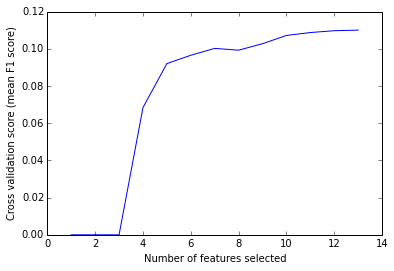

In [43]:
""" The F1 score is a weighted average of the precision and recall.
The relative contribution of precision and recall to the F1 score are equal.

The formula for the F1 score is:
F1 = 2 * (precision * recall) / (precision + recall) 

The best value is 1 and the worst value is 0."""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='f1')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean F1 score)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

#### Using average precision as metric

ranking [12 10 11  9  3  1  6  8 13  5  4  7  2]
Optimal number of features : 1


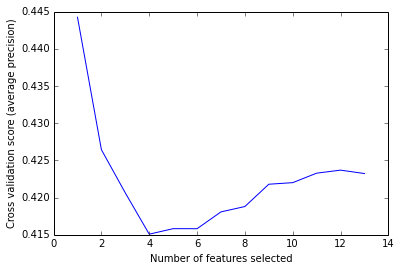

In [41]:
"""This score corresponds to the area under the precision-recall curve. When dealing with highly skewed classes, the PR curve
is more informative than the ROC curve. The goal in PR space is to be in the upper-right-hand corner.

The best value is 1 and the worst value is 0."""

from sklearn.feature_selection import RFECV

estimator = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
cv = 3
rfecv = RFECV(estimator, step=1, cv=cv, scoring='average_precision')
rfecv.fit(train_int_scaled, outcomes)

# feature rankings are ordered with lower values being more favorable
print 'ranking',rfecv.ranking_
# features ranked 1 are selected in optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# scale the cv scores to account for sklearn bug (it sums the cv scores and divides by n-1)
scores = rfecv.grid_scores_ * ((cv-1.0)/cv)

# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (average precision)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

## Model evaluation

I used ROC curves to evaluate the variance of the training data. I split the training data into 3 parts, and they all had the same AUC = 0.68 and overlapping ROC curves - implying very little data variance in this segment of the training data (there's more variance within the entire week of data). I also compared the ROC curves for the top and worst features. Feature I6 (AUC=0.67) is almost as good as all of the features combined (AUC=0.68), while I9 is no better than luck (AUC=0.50).  The precsion-recall curves show I6 (AUC=0.44) performing better alone then with the rest of the features (AUC=0.42).
 
This exploration shows that the top and worst features are consistent with a variety of error metrics, but the preferred model does change with your chosen error metric.

#### Confusion matrix

[[834525  14546]
 [278786  18140]]


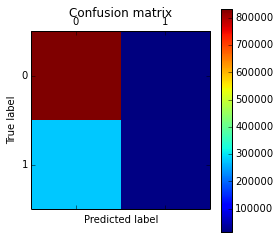

accuracy score = 0.744037724357


In [22]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier
classifier = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Show confusion matrix in a separate window
plt.figure()
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.plot(cm)
plt.show()

print 'accuracy score =',classifier.score(X_test, y_test)

#### ROC analysis

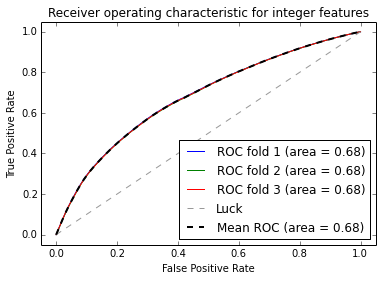

In [50]:
## Classification and ROC analysis ##

"""ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis.
This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero,
and a true positive rate of one. This is not very realistic, but it does mean that a larger area
under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate 
while minimizing the false positive rate.

This example shows the ROC response of different datasets, created from K-fold cross-validation. 
Taking all of these curves, it is possible to calculate the mean area under curve, and see the variance of 
the curve when the training set is split into different subsets. This roughly shows how the classifier output
is affected by changes in the training data, and how different the splits generated by K-fold cross-validation
are from one another."""

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

X = train_int_scaled
y = outcomes
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=3)
classifier = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
tpr = dict()
fpr = dict()
roc_auc = dict()

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area under the curve
    fpr[i], tpr[i], thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += sp.interp(mean_fpr, fpr[i], tpr[i])
    mean_tpr[0] = 0.0
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=1, label='ROC fold %d (area = %0.2f)' % ((i+1), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for integer features')
plt.legend(loc="lower right")
plt.show()

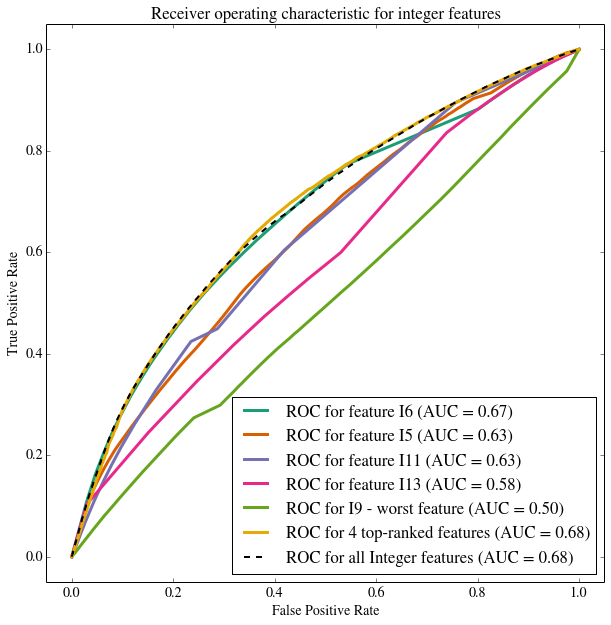

In [100]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

rcParams['figure.figsize'] = (10, 10)

# features with top ranking
ones = [4,5,10,12]

Xtrain4, Xtest4, Ytrain4, Ytest4 = train_test_split(train_int_scaled[:,[4]], outcomes, test_size=0.33, random_state=42)
Xtrain5, Xtest5, Ytrain5, Ytest5 = train_test_split(train_int_scaled[:,[5]], outcomes, test_size=0.33, random_state=42)
Xtrain10, Xtest10, Ytrain10, Ytest10 = train_test_split(train_int_scaled[:,[10]], outcomes, test_size=0.33, random_state=42)
Xtrain12, Xtest12, Ytrain12, Ytest12 = train_test_split(train_int_scaled[:,[12]], outcomes, test_size=0.33, random_state=42)
Xtrain8, Xtest8, Ytrain8, Ytest8 = train_test_split(train_int_scaled[:,[8]], outcomes, test_size=0.33, random_state=42)
Xtrain1s, Xtest1s, Ytrain1s, Ytest1s = train_test_split(train_int_scaled[:,ones], outcomes, test_size=0.33, random_state=42)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_int_scaled, outcomes, test_size=0.33, random_state=42)

# Run classifier and calculate PR curves
classifier = linear_model.LogisticRegression(penalty='l2', C=0.001, tol=1e-4)

#prob5 = classifier.fit(Xtrain5, Ytrain5).predict_proba(Xtest5)
fpr5, tpr5, thresholds5 = roc_curve(Ytest5, prob5[:, 1])
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, lw=3, label='ROC for feature I6 (AUC = %0.2f)' % roc_auc5)

#prob4 = classifier.fit(Xtrain4, Ytrain4).predict_proba(Xtest4)
fpr4, tpr4, thresholds4 = roc_curve(Ytest4, prob4[:, 1])
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, lw=3, label='ROC for feature I5 (AUC = %0.2f)' % roc_auc4)

#prob10 = classifier.fit(Xtrain10, Ytrain10).predict_proba(Xtest10)
fpr10, tpr10, thresholds10 = roc_curve(Ytest10, prob10[:, 1])
roc_auc10 = auc(fpr10, tpr10)
plt.plot(fpr10, tpr10, lw=3, label='ROC for feature I11 (AUC = %0.2f)' % roc_auc10)

#prob12 = classifier.fit(Xtrain12, Ytrain12).predict_proba(Xtest12)
fpr12, tpr12, thresholds12 = roc_curve(Ytest12, prob12[:, 1])
roc_auc12 = auc(fpr12, tpr12)
plt.plot(fpr12, tpr12, lw=3, label='ROC for feature I13 (AUC = %0.2f)' % roc_auc12)

#prob8 = classifier.fit(Xtrain8, Ytrain8).predict_proba(Xtest8)
fpr8, tpr8, thresholds8 = roc_curve(Ytest8, prob8[:, 1])
roc_auc8 = auc(fpr8, tpr8)
plt.plot(fpr8, tpr8, lw=3, label='ROC for I9 - worst feature (AUC = %0.2f)' % roc_auc8)

#prob1s = classifier.fit(Xtrain1s, Ytrain1s).predict_proba(Xtest1s)
fpr1s, tpr1s, thresholds1s = roc_curve(Ytest1s, prob1s[:, 1])
roc_auc1s = auc(fpr1s, tpr1s)
plt.plot(fpr1s, tpr1s, lw=3, label='ROC for 4 top-ranked features (AUC = %0.2f)' % roc_auc1s)

#prob = classifier.fit(Xtrain, Ytrain).predict_proba(Xtest)
fpr, tpr, thresholds = roc_curve(Ytest, prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC for all Integer features (AUC = %0.2f)' % roc_auc)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for integer features')
plt.legend(loc="lower right")
plt.show()

#### Precision-Recall analysis

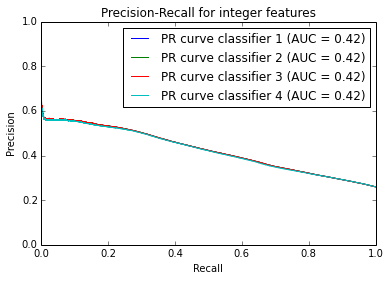

In [73]:
## Classification and PR analysis ##

"""
The PR curve is generated by varying the cut-off threshold over the whole range of the classifier's output
thus generating a curve from many working points.

A high area under the PR curve represents both high recall and high precision, where high precision relates
to a low false positive rate, and high recall relates to a low false negative rate. High scores for both
show that the classifier is returning accurate results (high precision), as well as returning a majority
of all positive results (high recall).

When dealing with highly skewed classes, the PR curve is more informative than the ROC curve. 
The goal in PR space is to be in the upper-right-hand corner.

The best AUC value is 1 and the worst value is 0."""

from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_int_scaled, outcomes, test_size=0.33, random_state=42)

# Run classifier and calculate PR curves
classifier1 = linear_model.LogisticRegression(penalty='l2', C=1.0, tol=1e-5)
classifier2 = linear_model.LogisticRegression(penalty='l1', C=1.0, tol=1e-5)
classifier3 = linear_model.LogisticRegression(penalty='l2', C=10000, tol=1e-5)
classifier4 = linear_model.LogisticRegression(penalty='l2', C=0.0001, tol=1e-5)

prob1 = classifier1.fit(Xtrain, Ytrain).predict_proba(Xtest)
prob2 = classifier2.fit(Xtrain, Ytrain).predict_proba(Xtest)
prob3 = classifier3.fit(Xtrain, Ytrain).predict_proba(Xtest)
prob4 = classifier4.fit(Xtrain, Ytrain).predict_proba(Xtest)

precision1, recall1, thresholds1 = precision_recall_curve(Ytest,prob1[:, 1])
precision2, recall2, thresholds2 = precision_recall_curve(Ytest,prob2[:, 1])
precision3, recall3, thresholds3 = precision_recall_curve(Ytest,prob3[:, 1])
precision4, recall4, thresholds4 = precision_recall_curve(Ytest,prob4[:, 1])

average_precision1 = average_precision_score(Ytest, prob1[:, 1])
average_precision2 = average_precision_score(Ytest, prob2[:, 1])
average_precision3 = average_precision_score(Ytest, prob3[:, 1])
average_precision4 = average_precision_score(Ytest, prob4[:, 1])

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall1, precision1, label='PR curve classifier 1 (AUC = %0.2f)' % average_precision1)
plt.plot(recall2, precision2, label='PR curve classifier 2 (AUC = %0.2f)' % average_precision2)
plt.plot(recall3, precision3, label='PR curve classifier 3 (AUC = %0.2f)' % average_precision3)
plt.plot(recall4, precision4, label='PR curve classifier 4 (AUC = %0.2f)' % average_precision4)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall for integer features')
plt.legend(loc="upper right")
plt.show()

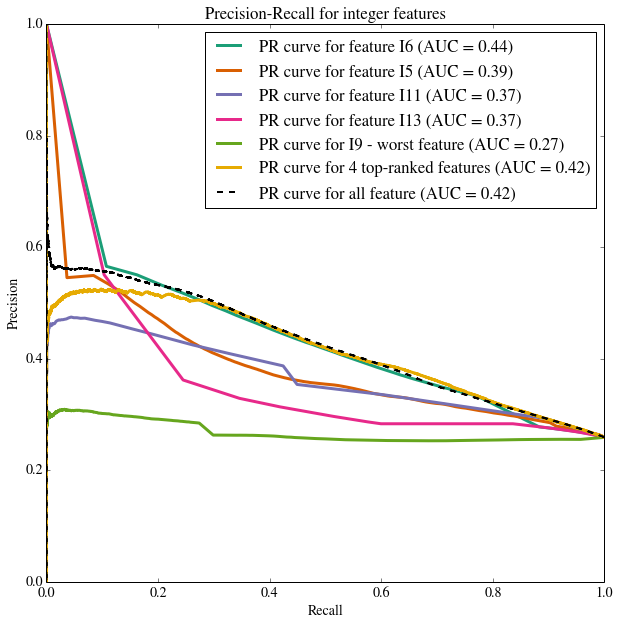

In [101]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.cross_validation import train_test_split

rcParams['figure.figsize'] = (10, 10)

# features with top ranking
ones = [4,5,10,12]

Xtrain4, Xtest4, Ytrain4, Ytest4 = train_test_split(train_int_scaled[:,[4]], outcomes, test_size=0.33, random_state=42)
Xtrain5, Xtest5, Ytrain5, Ytest5 = train_test_split(train_int_scaled[:,[5]], outcomes, test_size=0.33, random_state=42)
Xtrain10, Xtest10, Ytrain10, Ytest10 = train_test_split(train_int_scaled[:,[10]], outcomes, test_size=0.33, random_state=42)
Xtrain12, Xtest12, Ytrain12, Ytest12 = train_test_split(train_int_scaled[:,[12]], outcomes, test_size=0.33, random_state=42)
Xtrain8, Xtest8, Ytrain8, Ytest8 = train_test_split(train_int_scaled[:,[8]], outcomes, test_size=0.33, random_state=42)
Xtrain1s, Xtest1s, Ytrain1s, Ytest1s = train_test_split(train_int_scaled[:,ones], outcomes, test_size=0.33, random_state=42)

# Run classifier and calculate PR curves
classifier = linear_model.LogisticRegression(penalty='l2', C=0.0001, tol=1e-4)

prob5 = classifier.fit(Xtrain5, Ytrain5).predict_proba(Xtest5)
precision5, recall5, thresholds5 = precision_recall_curve(Ytest5, prob5[:, 1])
average_precision5 = average_precision_score(Ytest5, prob5[:, 1])
plt.plot(recall5, precision5, lw=3, label='PR curve for feature I6 (AUC = %0.2f)' % average_precision5)

prob4 = classifier.fit(Xtrain4, Ytrain4).predict_proba(Xtest4)
precision4, recall4, thresholds4 = precision_recall_curve(Ytest4, prob4[:, 1])
average_precision4 = average_precision_score(Ytest4, prob4[:, 1])
plt.plot(recall4, precision4, lw=3, label='PR curve for feature I5 (AUC = %0.2f)' % average_precision4)

prob10 = classifier.fit(Xtrain10, Ytrain10).predict_proba(Xtest10)
precision10, recall10, thresholds10 = precision_recall_curve(Ytest10,prob10[:, 1])
average_precision10 = average_precision_score(Ytest10, prob10[:, 1])
plt.plot(recall10, precision10, lw=3, label='PR curve for feature I11 (AUC = %0.2f)' % average_precision10)

prob12 = classifier.fit(Xtrain12, Ytrain12).predict_proba(Xtest12)
precision12, recall12, thresholds12 = precision_recall_curve(Ytest12,prob12[:, 1])
average_precision12 = average_precision_score(Ytest12, prob12[:, 1])
plt.plot(recall12, precision12, lw=3, label='PR curve for feature I13 (AUC = %0.2f)' % average_precision12)

prob8 = classifier.fit(Xtrain8, Ytrain8).predict_proba(Xtest8)
precision8, recall8, thresholds8 = precision_recall_curve(Ytest8,prob8[:, 1])
average_precision8 = average_precision_score(Ytest8, prob8[:, 1])
plt.plot(recall8, precision8, lw=3, label='PR curve for I9 - worst feature (AUC = %0.2f)' % average_precision8)

prob1s = classifier.fit(Xtrain1s, Ytrain1s).predict_proba(Xtest1s)
precision1s, recall1s, thresholds1s = precision_recall_curve(Ytest1s,prob1s[:, 1])
average_precision1s = average_precision_score(Ytest1s, prob1s[:, 1])
plt.plot(recall1s, precision1s, lw=3, label='PR curve for 4 top-ranked features (AUC = %0.2f)' % average_precision1s)

prob = classifier.fit(Xtrain, Ytrain).predict_proba(Xtest)
precision, recall, thresholds = precision_recall_curve(Ytest, prob[:, 1])
average_precision = average_precision_score(Ytest, prob[:, 1])
plt.plot(recall, precision, 'k--', label='PR curve for all feature (AUC = %0.2f)' % average_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall for integer features')
plt.legend(loc="upper right")
plt.show()